In [19]:
import pyforest
import warnings
warnings.simplefilter('ignore')

from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score

In [4]:
names = ['Sequence name',
         'mcg',
         'gvh',
         'alm',
         'mit',
         'erl',
         'pox',
         'vac',
         'nuc',
         'localization']

data_yeast = pd.read_csv('yeast.data', header = None, sep = '\s+', names = names)

data_pima = pd.read_csv('diabetes.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exercicio 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

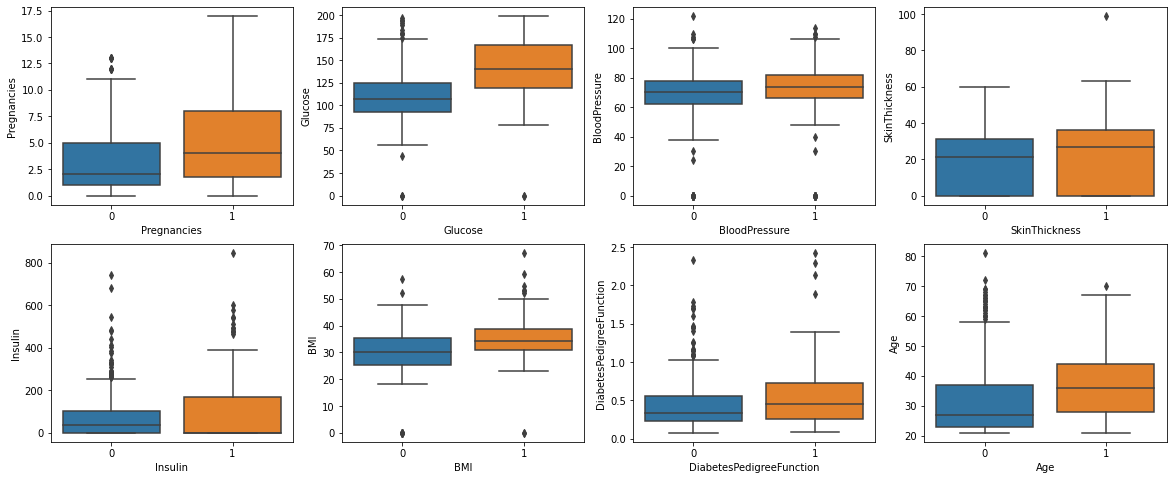

In [9]:
cols = data_pima.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 8))
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=data_pima)
    ax[i//4, i%4].set(xlabel=cols[i])
plt.show()

<IPython.core.display.Javascript object>

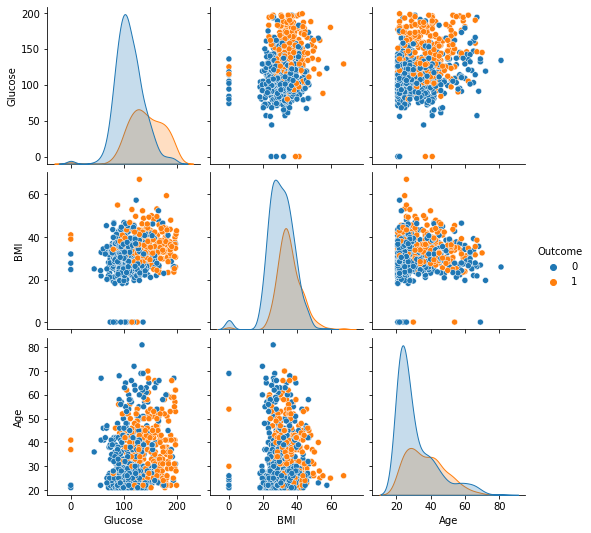

In [10]:
data_pima_sel = data_pima.drop(columns = ['BloodPressure', 'SkinThickness', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin'])
sns.pairplot(data_pima_sel, hue = 'Outcome');

Após análise aos gráficos apresentados, podemos observar rapidamente que as variáveis que melhor "separam" a variável alvo são a Glucose, BMI e Age. Contudo, as duas escolhidas (como requisitado pelo exercicio) foram a Glucose e BMI. A variável Age foi descartada pois tinha mais outliars.

## Methods comparison (kNN, Logistic Regression, QDA)

In [48]:
data_pima_clean = data_pima_sel[(data_pima['Glucose'] != 0) & (data_pima['BMI'] != 0)]

data_pima_clean = data_pima_clean.sample(frac=1).reset_index(drop=True)

In [49]:
data_pima_sel_final = data_pima_clean.drop(columns = 'Age')

column_names = ['Glucose', 'BMI']
temp = data_pima_sel_final[column_names].values
temp_scaled = MinMaxScaler().fit_transform(temp)

data_pima_sel_final[column_names] = temp_scaled


X = data_pima_sel_final.drop(columns = 'Outcome').values


y = data_pima_sel_final.loc[:,'Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify= y)

In [43]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

### Logistic Regression

In [52]:
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
y_pred_trainLogReg = modelLogReg.predict(x_train)
y_pred_testLogReg = modelLogReg.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainLogReg),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testLogReg), 4))


SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score.append(f1_score(y_test1, modelLogReg.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score),4),'+/-', round(np.std(score),4))

F1 score on training set:  0.5682 
F1 score on test set:  0.6517


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

F1 score on 5-fold test data:  0.5099 +/- 0.1841


ROC AUC=0.843


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

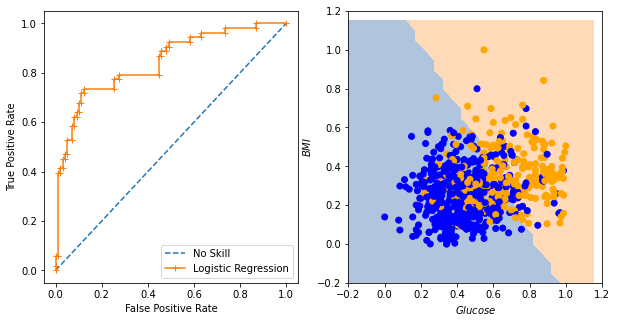

In [53]:
#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('ROC AUC=%.3f' % (LogReg_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelLogReg,X)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(X[:,0],X[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

### Quadratic Discriminant Analysis

In [54]:
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
y_pred_trainQDA = modelQDA.predict(x_train)
y_pred_testQDA = modelQDA.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_trainQDA),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_testQDA), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_QDA = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_QDA.append(f1_score(y_test1, modelQDA.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_QDA),4),'+/-', round(np.std(score_QDA),4))


F1 score on training set:  0.6146 
F1 score on test set:  0.6739


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

F1 score on 5-fold test data:  0.5587 +/- 0.1311


QDA ROC AUC=0.842
LR ROC AUC=0.843


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

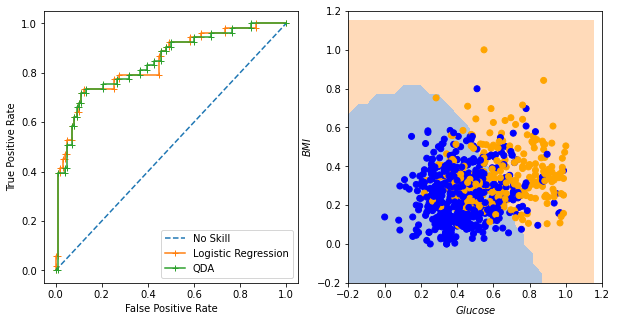

In [91]:
#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelQDA,X)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(X[:,0],X[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

### kNN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

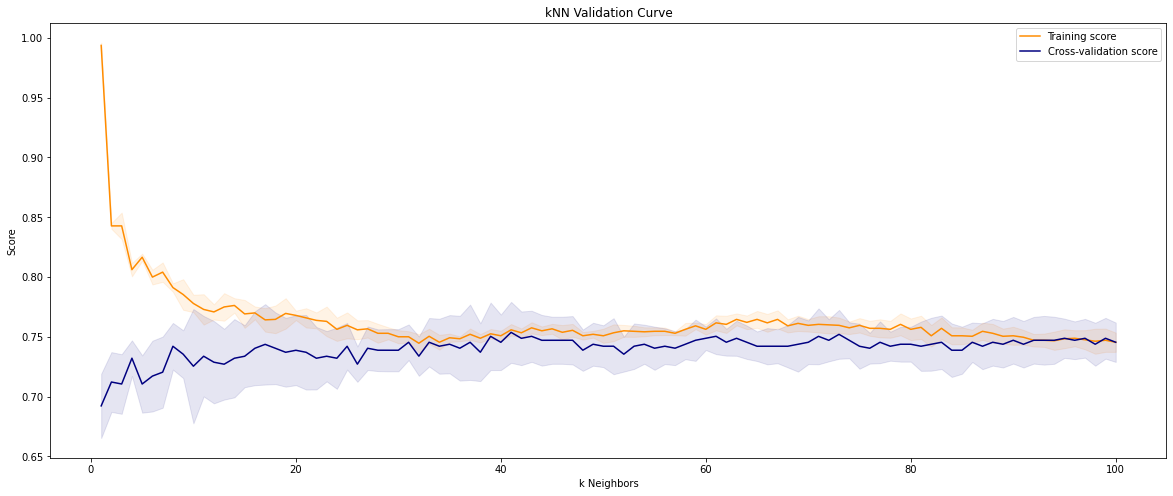

<IPython.core.display.Javascript object>

Best K is 41


In [88]:
#Determination of k
modelkNN = kNN()
param_range = [*range(1,101)]
rg = np.array([*range(1,101)])
train_scores, test_scores = validation_curve(modelkNN, x_train, y_train, param_name="n_neighbors", param_range=param_range, scoring="accuracy", n_jobs=6)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(20, 8))
plt.title("kNN Validation Curve")
plt.xlabel("k Neighbors")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
plt.legend(loc="best")
plt.show()

print("Best K is %d" %rg[np.where(test_scores_mean == max(test_scores_mean))][0])

In [61]:
modelkNN = kNN(n_neighbors=50)
modelkNN.fit(x_train, y_train)
y_pred_train_kNN = modelkNN.predict(x_train)
y_pred_test_kNN = modelkNN.predict(x_test)
print('F1 score on training set: ',round(f1_score(y_train, y_pred_train_kNN),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test_kNN), 4))

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
score_kNN = []
for train_index, test_index in SKF.split(x_test, y_test):
    x_test1 = x_train[test_index]
    y_test1 = y_train[test_index]
    score_kNN.append(f1_score(y_test1, modelkNN.predict(x_test1)))
print('F1 score on 5-fold test data: ',round(np.mean(score_kNN),4),'+/-', round(np.std(score_kNN),4))

F1 score on training set:  0.6098 
F1 score on test set:  0.64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

F1 score on 5-fold test data:  0.5638 +/- 0.1284


QDA ROC AUC=0.842
LR ROC AUC=0.843
kNN ROC AUC=0.844


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

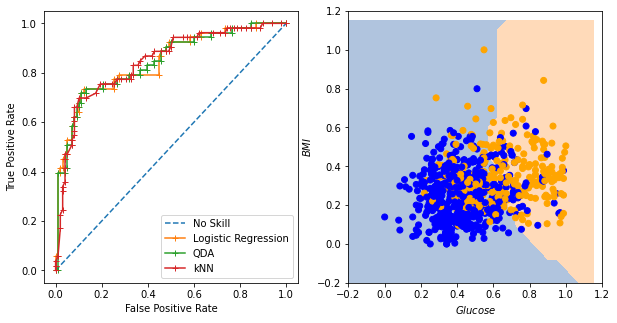

In [93]:
#ROC AUC and ROC curves
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
print('kNN ROC AUC=%.3f' % (kNN_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))
# plot the roc curves
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
ax1.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
ax1.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()

#plot decision boundary   
plot_classifier_boundary(modelkNN,X)
cmap = colors.ListedColormap(['blue','orange'])
ax2.scatter(X[:,0],X[:,1],color=cmap(y))
ax2.set_xlabel('$Glucose$')
ax2.set_ylabel('$BMI$')

plt.show();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

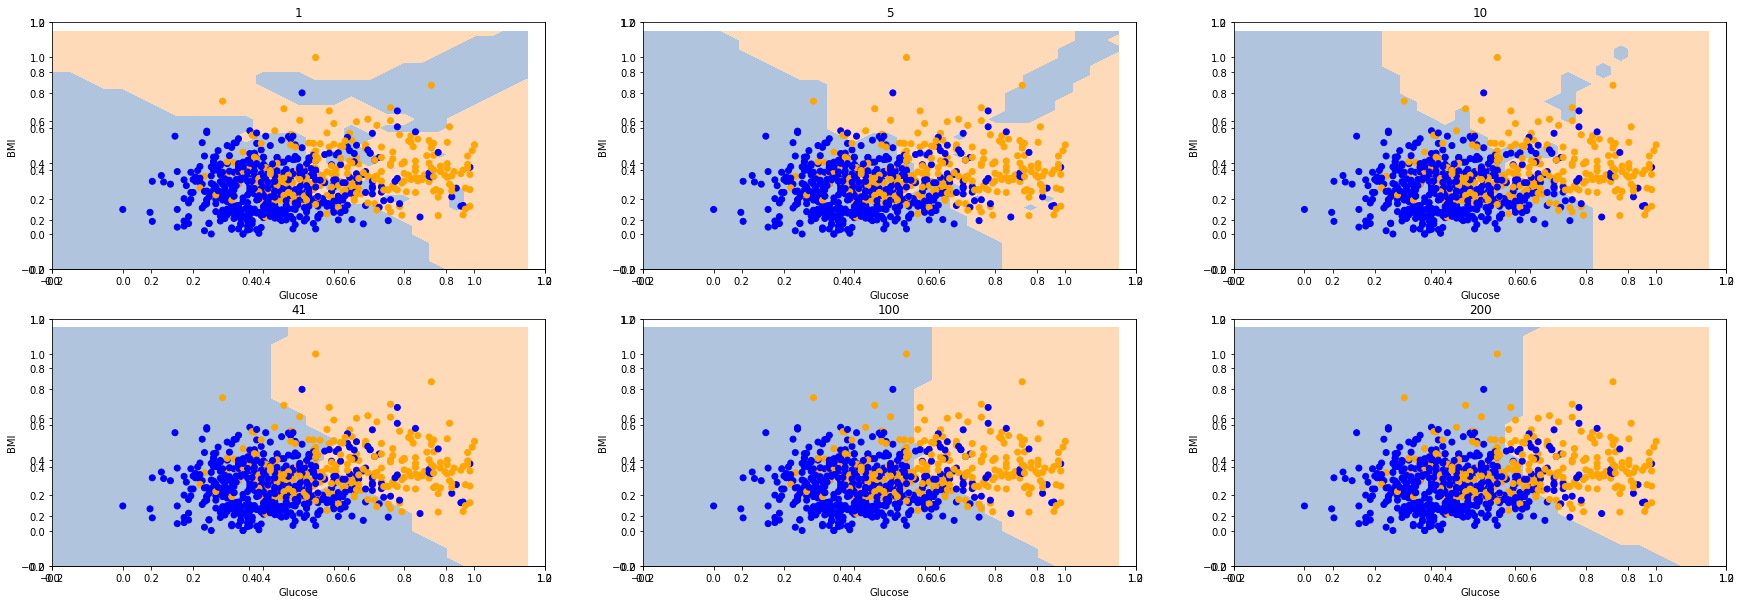

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
k = [1,5,10,41,100,200]
cmap = colors.ListedColormap(['blue','orange'])
#for i in range(len(k)):
 #   modelkNN = kNN(n_neighbors=k[i])
  #  modelkNN.fit(x_train, y_train)
   # plot_classifier_boundary(modelkNN,X)
    #
    #ax[i//3, i%3].scatter(X[:,0],X[:,1],color=cmap(y))
    #ax[i//3, i%3].set_xlabel('$Glucose$')
    #ax[i//3, i%3].set_ylabel('$BMI$')
       
for i in range(len(k)):
    modelkNN = kNN(n_neighbors=k[i])
    modelkNN.fit(x_train, y_train)
    ax = fig.add_subplot(2,3, i +1)
    plot_classifier_boundary(modelkNN, X, h = .05)
    ax.scatter(X[:,0],X[:,1],color=cmap(y))
    ax.set_title(k[i])
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BMI')
